In [ ]:
import matplotlib.pyplot as plt
from pgvector.psycopg import register_vector
from pathlib import Path
import psycopg
import torch
import torchvision
from tqdm import tqdm

In [7]:
DATA_HOME = Path.home() / "data"

In [ ]:
# establish connection
conn = psycopg.connect(dbname="ai", autocommit=True)
conn.execute("CREATE EXTENSION IF NOT EXISTS vector")
register_vector(conn)

In [ ]:
# load images
transform = torchvision.transforms.Compose(
  [torchvision.transforms.ToTensor(), torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)
dataset = torchvision.datasets.CIFAR10(root=DATA_HOME, train=True, download=True, transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1000)

# load pretrained model
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = torchvision.models.resnet18(weights="DEFAULT")
model.fc = torch.nn.Identity()
model.to(device)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [9]:
def generate_embeddings(inputs):
  return model(inputs.to(device)).detach().cpu().numpy()

In [10]:
seed = True

In [11]:
# generate and store embeddings
if seed:
  conn.execute("DROP TABLE IF EXISTS images")
  conn.execute("CREATE TABLE images (id bigserial PRIMARY KEY, embedding vector(512))")

  print("Generating embeddings")
  for data in tqdm(dataloader):
    embeddings = generate_embeddings(data[0])

    sql = "INSERT INTO images (embedding) VALUES " + ",".join(["(%s)" for _ in embeddings])
    params = [embedding for embedding in embeddings]
    conn.execute(sql, params)

Generating embeddings


100%|██████████| 50/50 [00:08<00:00,  5.64it/s]


In [ ]:
# load 5 random unseen images
queryset = torchvision.datasets.CIFAR10(root=DATA_HOME, train=False, download=True, transform=transform)
queryloader = torch.utils.data.DataLoader(queryset, batch_size=5, shuffle=True)
images = next(iter(queryloader))[0]

100%|██████████| 170M/170M [01:14<00:00, 2.29MB/s] 


In [ ]:
# generate and query embeddings
results = []
embeddings = generate_embeddings(images)
for image, embedding in zip(images, embeddings):
  result = conn.execute("SELECT id FROM images ORDER BY embedding <=> %s LIMIT 5", (embedding,)).fetchall()
  nearest_images = [dataset[row[0] - 1][0] for row in result]
  results.append([image] + nearest_images)

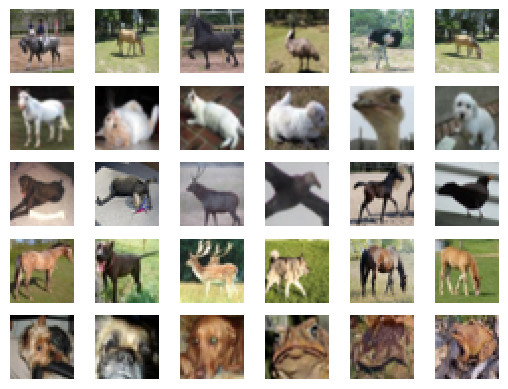

In [ ]:
# show images
fig, axs = plt.subplots(len(results), len(results[0]))
for i, result in enumerate(results):
  for j, image in enumerate(result):
    ax = axs[i, j]
    ax.imshow((image / 2 + 0.5).permute(1, 2, 0).numpy())
    ax.set_axis_off()
plt.show(block=True)